# Imports

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from sklearn.metrics import roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import optuna

from tqdm.auto import tqdm

# Read data

In [194]:
dat = pd.read_csv('../data/train.csv')
dat = dat.drop(columns=['id'])

cc_dat = pd.read_csv('../data/credit_risk_dataset.csv')

merged_dat = pd.concat([dat, cc_dat])

In [195]:
merged_dat.drop_duplicates(subset=dat.columns, keep='first', inplace=True)
merged_dat.dropna(inplace=True)

In [196]:
merged_dat.isnull().sum(), merged_dat.duplicated().sum(), merged_dat.shape

(person_age                    0
 person_income                 0
 person_home_ownership         0
 person_emp_length             0
 loan_intent                   0
 loan_grade                    0
 loan_amnt                     0
 loan_int_rate                 0
 loan_percent_income           0
 cb_person_default_on_file     0
 cb_person_cred_hist_length    0
 loan_status                   0
 dtype: int64,
 0,
 (87146, 12))

# EDA

In [197]:
data = merged_dat.copy()

target = 'loan_status'

categorcial_features = list(merged_dat.select_dtypes(include=['object']).columns)

numerical_features = merged_dat.select_dtypes(exclude=['object']).columns
numerical_features = list(numerical_features.drop(target))

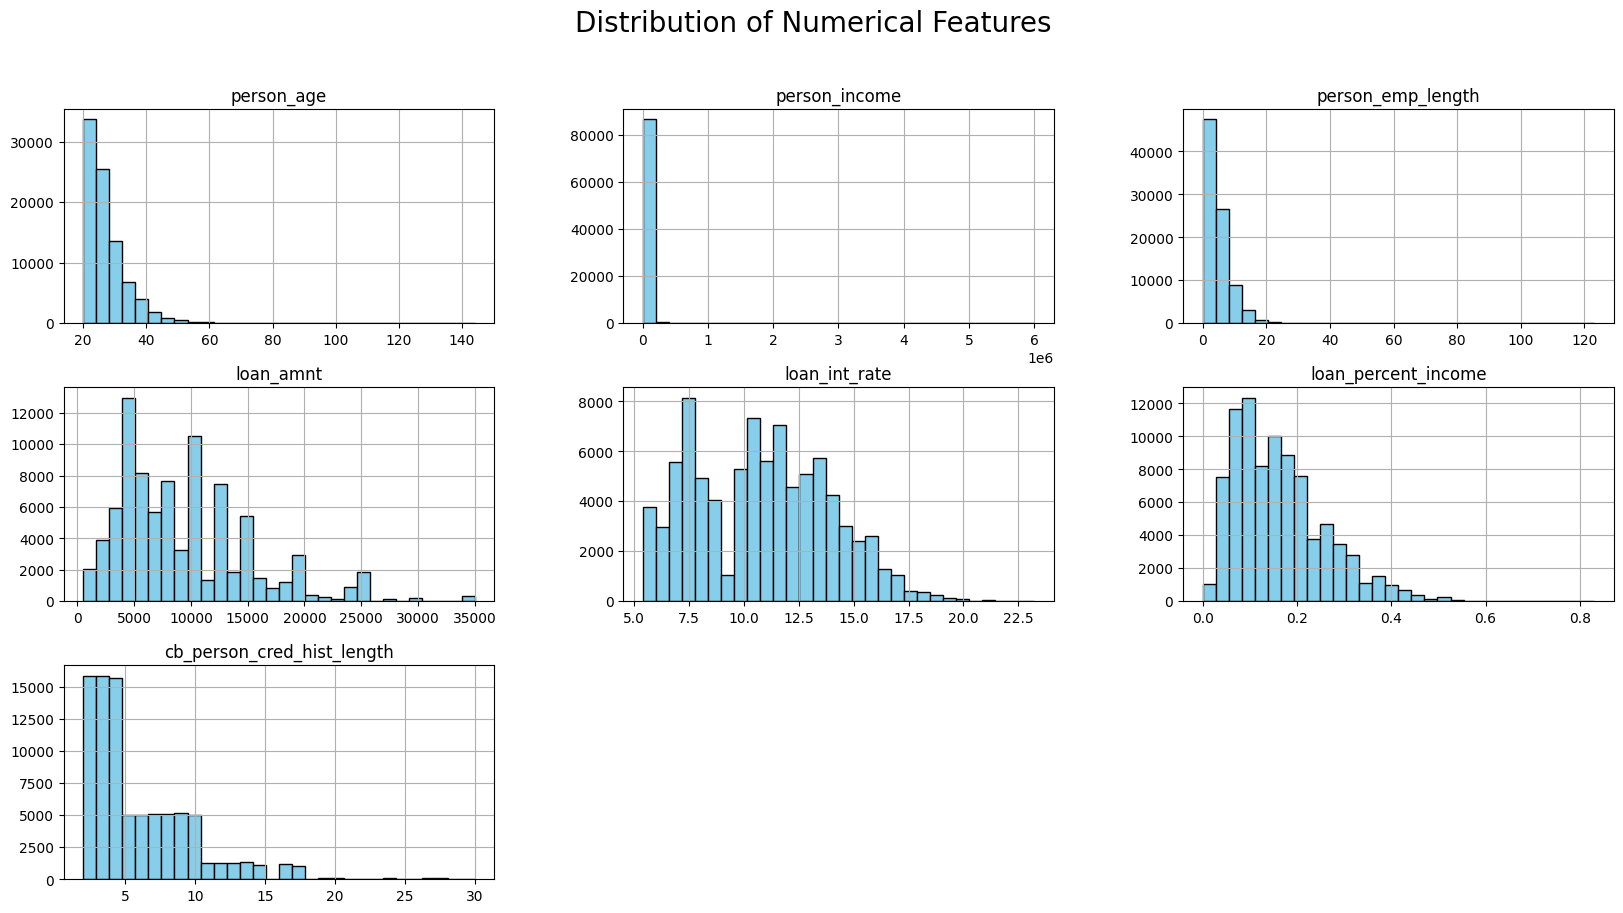

In [198]:
data[numerical_features].hist(bins=30, figsize=(20,10), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=20)
plt.show()

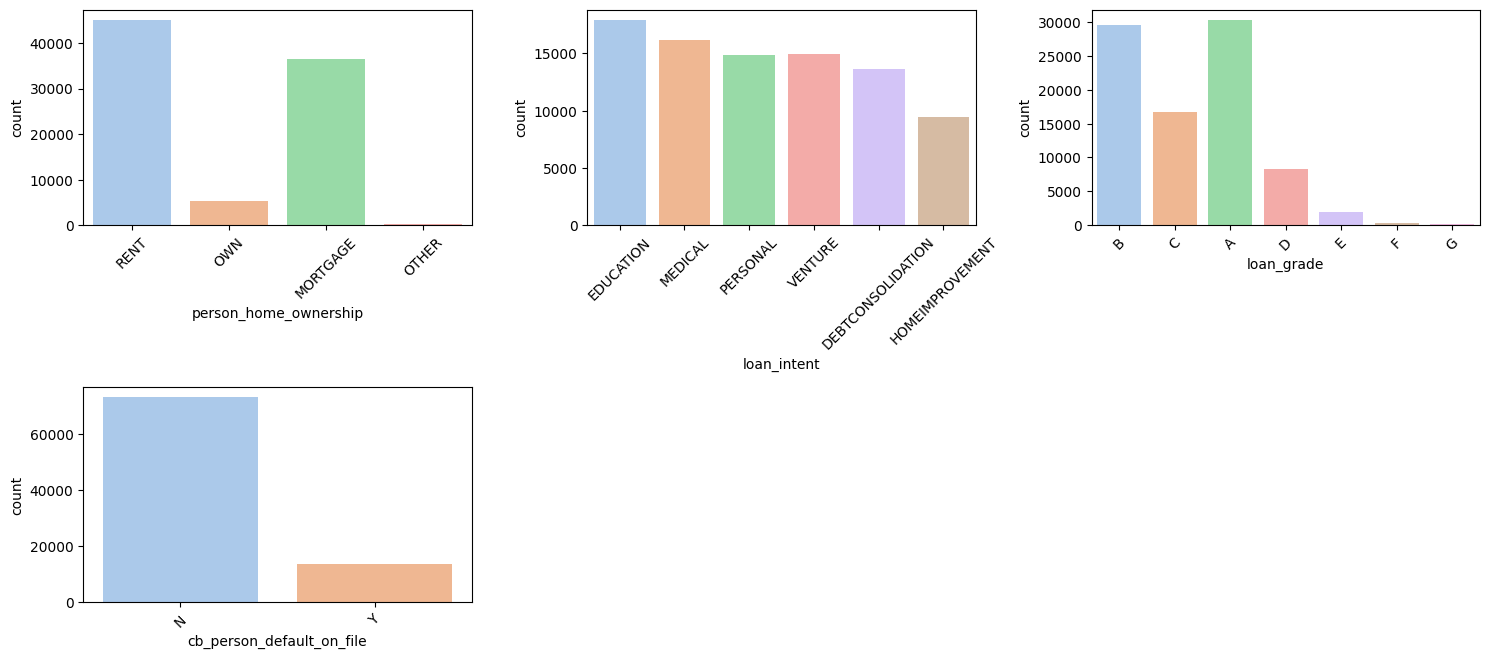

In [199]:
plt.figure(figsize=(15, 10))
for i, col in enumerate (categorcial_features, 1):
	plt.subplot(3, 3, i)
	sns.countplot(x=col, data=data, hue=col, palette='pastel', legend=False)
	plt.xticks(rotation=45)

plt.tight_layout()

# Some Processing

In [200]:
def remove_outliers(df, columns):
	Q1 = df[columns].quantile(0.25)
	Q3 = df[columns].quantile(0.75)
	IQR = Q3 - Q1
	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR
	df = df[(df[columns] > lower_bound) & (df[columns] < upper_bound)]
	return df

In [201]:
# Remove outliers using z-score
from scipy import stats
def remove_outliers_zscore(df, columns, threshold=3):
	z_scores = np.abs(stats.zscore(df[columns]))
	df = df[(z_scores < threshold).all(axis=1)]
	return df 

In [202]:
data_no_outliers = remove_outliers_zscore(data, numerical_features)

Text(0.5, 0.98, 'Distribution of Numerical Features without Outliers')

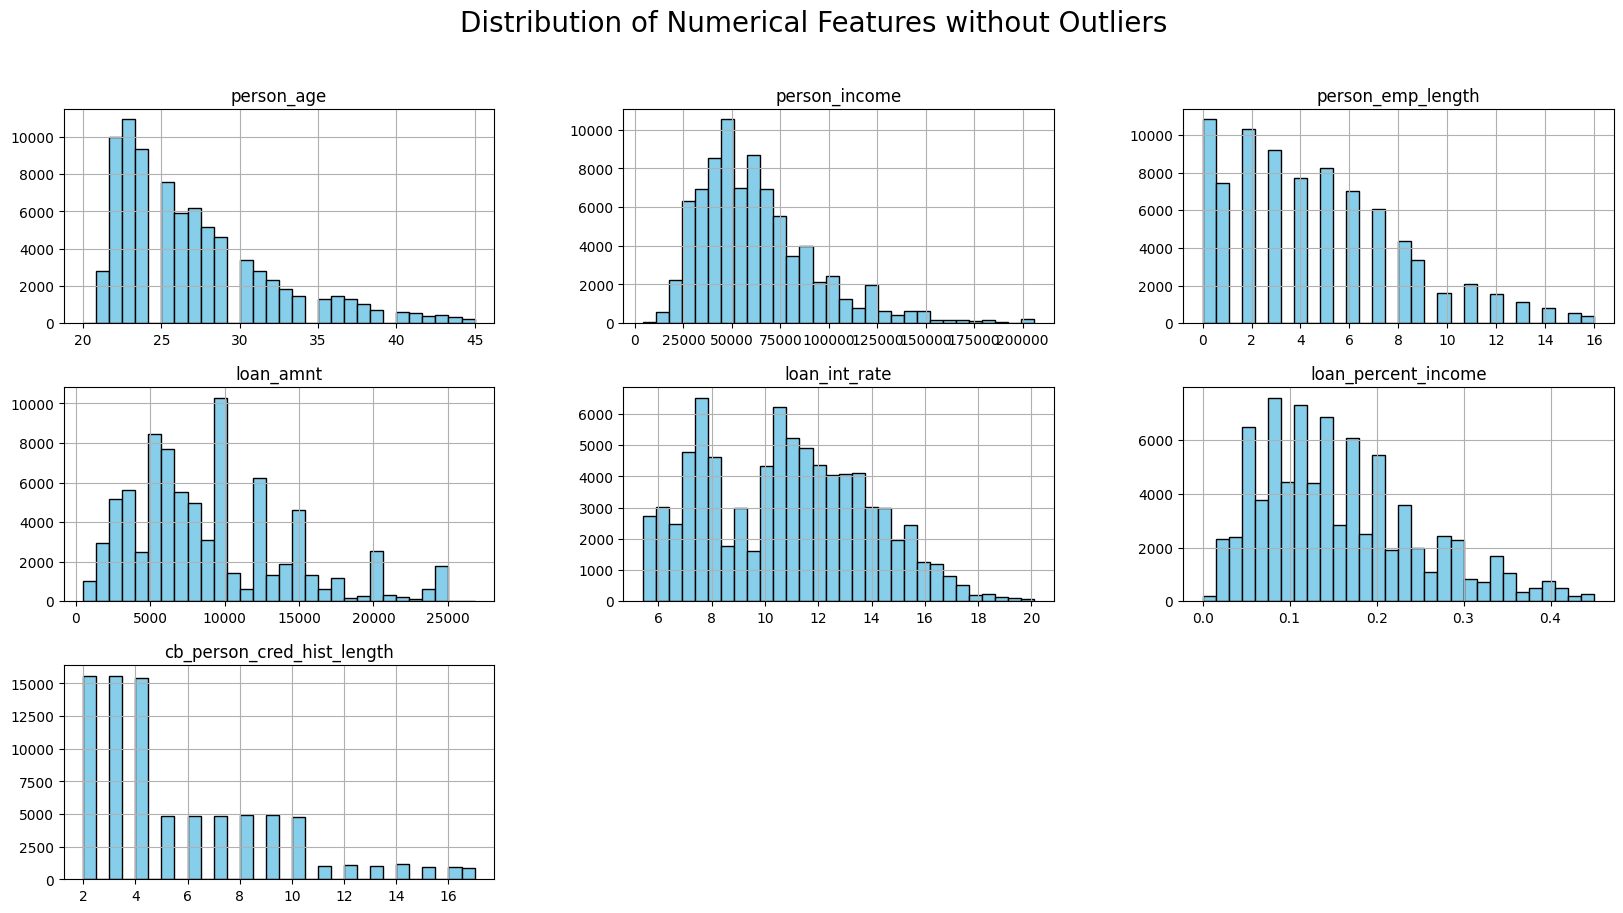

In [203]:
data_no_outliers[numerical_features].hist(bins=30, figsize=(20,10), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Numerical Features without Outliers', fontsize=20)

# Preprocessing

In [204]:
X = data_no_outliers.drop(columns=target)
y = data_no_outliers[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=907, stratify=y)

X_train.shape, X_test.shape

((66139, 11), (16535, 11))

In [205]:
resampler = SMOTENC(sampling_strategy=0.25, random_state=907, categorical_features=[X_train.columns.get_loc(col) for col in categorcial_features], k_neighbors=8)

X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)

In [206]:
cat_cols = X_train.select_dtypes(include=['object']).columns
num_cols = X_train.select_dtypes(exclude=['object']).columns

def log_transform():
	return FunctionTransformer(np.log1p)


preprocessor = ColumnTransformer(
	transformers=[
		# ('num', StandardScaler(), numerical_features),
		('log', log_transform(), numerical_features),
		('cat', OneHotEncoder(), categorcial_features)
	]
)

preprocessor.fit(X_resampled)

X_train_prep = preprocessor.transform(X_resampled)
X_test_prep = preprocessor.transform(X_test)

scaler = StandardScaler()

X_train_prep = scaler.fit_transform(X_train_prep)
X_test_prep = scaler.transform(X_test_prep)

array([[<Axes: title={'center': 'person_age'}>,
        <Axes: title={'center': 'person_income'}>,
        <Axes: title={'center': 'person_emp_length'}>],
       [<Axes: title={'center': 'loan_amnt'}>,
        <Axes: title={'center': 'loan_int_rate'}>,
        <Axes: title={'center': 'loan_percent_income'}>],
       [<Axes: title={'center': 'cb_person_cred_hist_length'}>, <Axes: >,
        <Axes: >]], dtype=object)

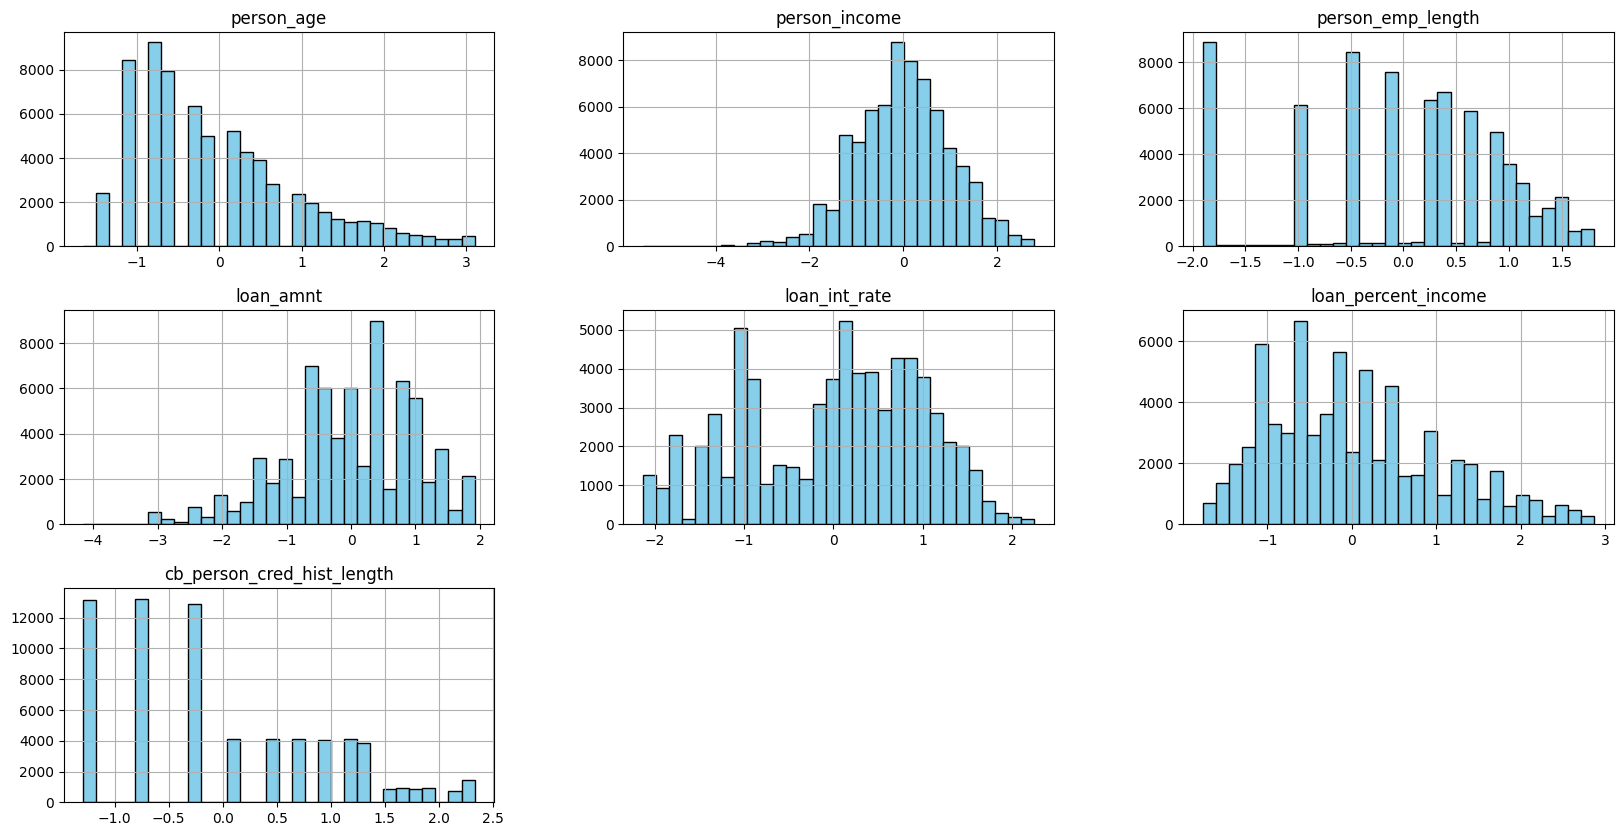

In [207]:
data_prep = pd.DataFrame(X_train_prep, columns=numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out()))
data_prep[numerical_features].hist(bins=30, figsize=(20,10), color='skyblue', edgecolor='black')

# Models

In [208]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=907)

model_names = ['XGBoost', 'LightGBM', 'CatBoost']

In [209]:
def xgb_objective(trial, X, y, skf):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'lambda': trial.suggest_float('lambda', 1e-8, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 10.0, log=True),
    }

    # Cross-validation with StratifiedKFold
    auc_scores = []

    for fold_idx, (train_idx, valid_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)

        # Training with early stopping
        bst = xgb.train(
            param, 
            dtrain, 
            evals=[(dvalid, 'validation')], 
            num_boost_round=5000, 
            early_stopping_rounds=50, 
            verbose_eval=500
        )

        # Predict probabilities
        y_pred = bst.predict(dvalid)
        auc = roc_auc_score(y_valid, y_pred)
        auc_scores.append(auc)

        # Output the AUC
        trial.report(auc, fold_idx)

    
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    # Log the mean and std AUC
    trial.set_user_attr('std_auc', std_auc)

    return mean_auc


def optimize_xgb(X, y, skf, n_trials=200, timeout=3600*2):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: xgb_objective(trial, X, y, skf), n_trials=n_trials, timeout=timeout)
    
    print(f"Best Score: {study.best_value}")
    print(f"Best Params: {study.best_params}")
    print(f"Best std_auc: {study.best_trial.user_attrs['std_auc']}")
    
    return study

In [211]:
xgb_study = optimize_xgb(X_train_prep, y_resampled, skf=skf, n_trials=200, timeout=60)

[I 2024-10-13 01:47:15,609] A new study created in memory with name: no-name-81e3de61-844d-44c3-8505-e2fa5badc1bc


[0]	validation-auc:0.88495
[117]	validation-auc:0.92426
[0]	validation-auc:0.88414
[500]	validation-auc:0.92356
[1000]	validation-auc:0.92643
[1500]	validation-auc:0.92914
[2000]	validation-auc:0.93206


[W 2024-10-13 01:47:48,500] Trial 0 failed with parameters: {'lambda': 8.285168750665415, 'alpha': 0.7501936358026858, 'colsample_bytree': 0.7130670232865127, 'subsample': 0.7723640495627841, 'learning_rate': 0.0010535666568345686, 'max_depth': 5, 'min_child_weight': 9, 'gamma': 3.486834741149646e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\Denis\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\Denis\AppData\Local\Temp\ipykernel_7280\177604683.py", line 55, in <lambda>
    study.optimize(lambda trial: xgb_objective(trial, X, y, skf), n_trials=n_trials, timeout=timeout)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Denis\AppData\Local\Temp\ipykernel_7280\177604683.py", line 26, in xgb_objective
    bst = xgb.train(
          ^^^^^^^^^^
  File "

KeyboardInterrupt: 

In [167]:
xgb_study.trials_dataframe().sort_values(by='value', ascending=False)

best_params = xgb_study.best_params
best_score = xgb_study.best_value
print(f"Best AUC: {best_score} in iteration {xgb_study.best_trial.number}. Std AUC: {xgb_study.best_trial.user_attrs['std_auc']}")

Best AUC: 0.9646637227837889 in iteration 0. Std AUC: 0.0013395062191500218


In [176]:
params = best_params.copy()
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'auc'

xgb_model = xgb.train(
	params, 
	xgb.DMatrix(X_train_prep, label=y_resampled), 
	num_boost_round=10000,
	verbose_eval=500,
	evals=[(xgb.DMatrix(X_test_prep, label=y_test), 'validation')],
	early_stopping_rounds=500
)

[0]	validation-auc:0.88324
[500]	validation-auc:0.95410
[1000]	validation-auc:0.95504
[1346]	validation-auc:0.95491
